In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# data preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder

# Model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Importing the Dataset

In [2]:
data = pd.read_csv(r"C:\Users\shrey\Desktop\spam.csv", encoding='latin1')

In [3]:
data.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5553,ham,Hahaha..use your brain dear,NaN,NaN,NaN
4977,ham,JADE ITS PAUL. Y DIDNåÕT U TXT ME? DO U REMEMB...,NaN,NaN,NaN
1636,ham,"No shit, but I wasn't that surprised, so I wen...",NaN,NaN,NaN
1693,ham,Was gr8 to see that message. So when r u leavi...,NaN,NaN,NaN
304,spam,SMS. ac Blind Date 4U!: Rodds1 is 21/m from Ab...,NaN,NaN,NaN


# Data Cleaning

In [4]:
data.shape

(5572, 5)

In [5]:
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

In [6]:
data.rename(columns={'v1': 'result', 'v2': 'sms'}, inplace=True) 

In [7]:
data.head(5)

,result,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
data.isnull().sum()

result    0
sms       0
dtype: int64

In [9]:
data.duplicated().sum()

np.int64(403)

In [10]:
data = data.drop_duplicates(keep='first')

In [11]:
data.shape

(5169, 2)

# EDA

# 1) Distribution of Labels

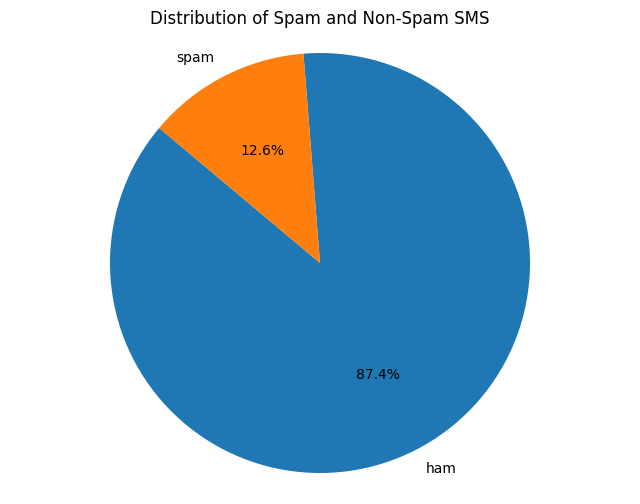

In [12]:
data['result'].value_counts()

# Plotting distribution
plt.figure(figsize=(8, 6))
plt.pie(data['result'].value_counts(), labels=data['result'].value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam and Non-Spam SMS')
plt.axis('equal')
plt.show()

### From the above graph we can see most SMS in the dataset (87.4%) are non-spam (ham), while only a smaller portion (12.6%) are classified as spam. This difference is important because it affects how well our model can spot spam SMS. Since there are many more non-spam SMS, the model might become biased and miss some spam SMS. To fix this, we need to use special techniques when training and testing our model. By doing this, we can make sure our model is good at finding both spam and non-spam SMS, keeping our SMS inboxes safe and clutter-free.

In [13]:
pip install nltk


Note: you may need to restart the kernel to use updated packages.


In [14]:
import nltk

# Download the 'punkt' tokenizer models
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [15]:
data['Length'] = data['sms'].apply(len)  
data['num_words'] = data['sms'].apply(lambda sms: len(word_tokenize(sms))) 
data['num_sentence'] = data['sms'].apply(lambda sms: len(sent_tokenize(sms)))  

In [16]:
data.head(2)

,result,sms,Length,num_words,num_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2


# 2) Average Length of SMS for Spam and Ham

Average Length of Spam SMS: 137.89127105666157
Average Length of Ham SMS: 70.45925597874225


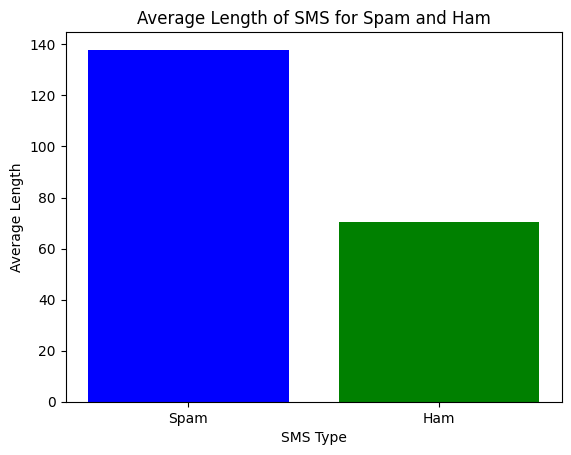

In [17]:
avg_length_spam = data[data['result'] == 'spam']['Length'].mean()
avg_length_ham = data[data['result'] == 'ham']['Length'].mean()
print("Average Length of Spam SMS:", avg_length_spam)
print("Average Length of Ham SMS:", avg_length_ham)

# Plotting the graph
plt.bar(['Spam', 'Ham'], [avg_length_spam, avg_length_ham], color=['Blue', 'green'])
plt.title('Average Length of SMS for Spam and Ham')
plt.xlabel('SMS Type')
plt.ylabel('Average Length')
plt.show()

#### After looking at the lengths of spam and regular (ham) SMS, we found that spam SMS are much longer on average, around 137 characters. On the other hand, regular SMS are much shorter, averaging about 70 characters. This means that spam SMS tend to be more wordy and detailed, possibly because they're trying to grab your attention with lots of information. Regular SMS, like the ones you get from friends or for work, are usually shorter and to the point. Understanding this helps us make better tools to filter out spam and keep our inboxes organized.

# 3) Average Word of SMS for Spam and Ham

Average Words of Spam SMS: 27.6676875957121
Average Words of Ham SMS: 17.12378210806023


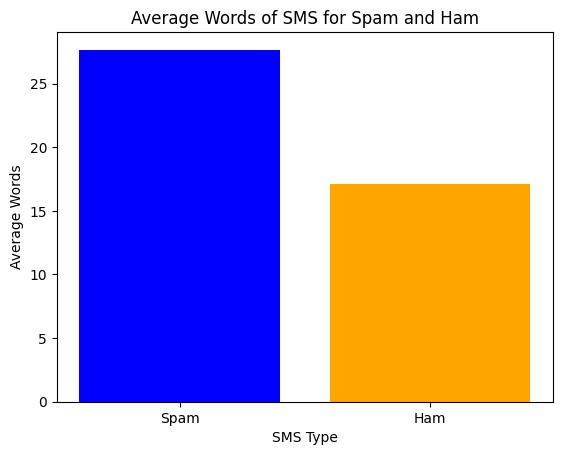

In [18]:
avg_word_spam = data[data['result'] == 'spam']['num_words'].mean()
avg_word_ham = data[data['result'] == 'ham']['num_words'].mean()
print("Average Words of Spam SMS:", avg_word_spam)
print("Average Words of Ham SMS:", avg_word_ham)

# Plotting the graph
plt.bar(['Spam', 'Ham'], [avg_word_spam, avg_word_ham], color=['Blue', 'orange'])
plt.title('Average Words of SMS for Spam and Ham')
plt.xlabel('SMS Type')
plt.ylabel('Average Words')
plt.show()

#### From the above graph we can see that spam SMS are longer, with an average of about 27 words per SMS. On the other hand, regular ham SMS are shorter, averaging around 17 words per SMS. This means spam SMS tend to be more wordy, maybe because they contain advertisements or misleading information. Meanwhile, regular SMS are more straightforward and direct. Understanding this helps us create better filters to catch spam and keep our inboxes clean from unwanted messages, making it easier to find the SMS that matter to us.

# 4) Average Sentence of SMS for Spam and Ham

Average Sentences of Spam SMS: 2.970903522205207
Average Sentences of Ham SMS: 1.8201948627103632


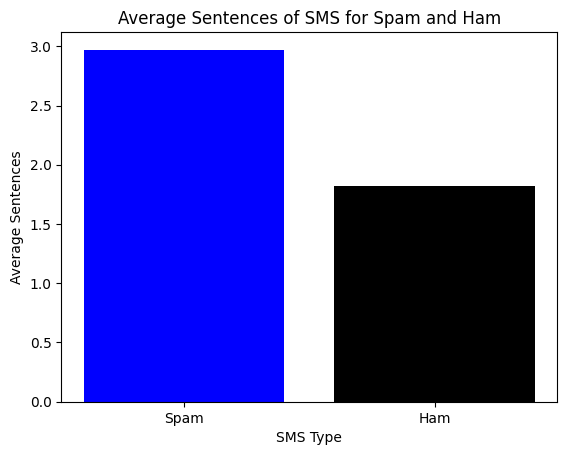

In [19]:
avg_sentence_spam = data[data['result'] == 'spam']['num_sentence'].mean()
avg_sentence_ham = data[data['result'] == 'ham']['num_sentence'].mean()
print("Average Sentences of Spam SMS:", avg_sentence_spam)
print("Average Sentences of Ham SMS:", avg_sentence_ham)

# Plotting the graph
plt.bar(['Spam', 'Ham'], [avg_sentence_spam, avg_sentence_ham], color=['Blue', 'black'])
plt.title('Average Sentences of SMS for Spam and Ham')
plt.xlabel('SMS Type')
plt.ylabel('Average Sentences')
plt.show()

#### From the above graph we can see that that spam SMS tend to have longer sentences compared to regular SMS. On average, spam SMS have about 3 sentences, while regular SMS have about 2 sentences. This means that spam SMS might be trying to say more or convince you of something, while regular SMS are usually shorter and more straightforward. Understanding this difference helps us build better systems to detect and filter out spam SMS, keeping our SMS inboxes cleaner and safer for everyone to use.

# 5) Relationship between Length and Spam

Correlation coefficient between SMS length and spam classification: 0.38471706671430644


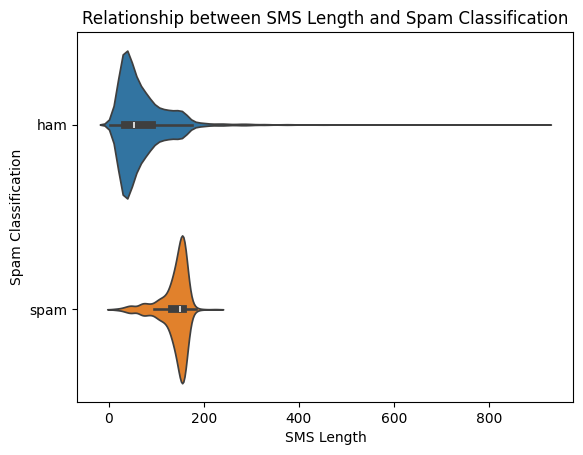

In [20]:
correlation = data['Length'].corr((data['result'] == 'spam').astype(int))
print("Correlation coefficient between SMS length and spam classification:", correlation)

# Visualization
sns.violinplot(data=data, x='Length', y='result', hue='result')
plt.xlabel('SMS Length')
plt.ylabel('Spam Classification')
plt.title('Relationship between SMS Length and Spam Classification')
plt.show()

#### As we found that there is a positive correlation (correlation coefficient: 0.38) between SMS length and spam classification. This means that, on average, spam SMS tend to be slightly longer than non-spam SMS. However, it's important to note that the correlation is not very strong, indicating that other factors may also influence whether an SMS is classified as spam. Nonetheless, understanding this relationship can help improve spam detection algorithms by considering SMS length as one of the features in the classification process, alongside other relevant factors.

# 6) Relationship between Features

The Relationship between Features are                  Length  num_words  num_sentence
Length        1.000000   0.965760      0.624139
num_words     0.965760   1.000000      0.679971
num_sentence  0.624139   0.679971      1.000000


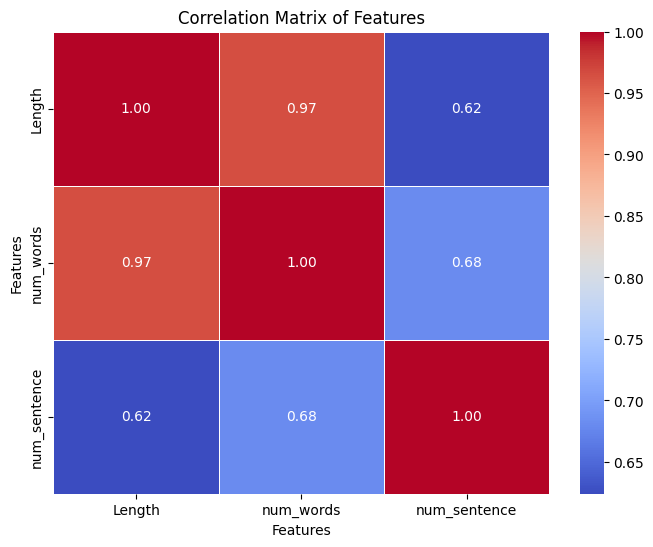

In [21]:
correlation_matrix = data[['Length', 'num_words', 'num_sentence']].corr()
print("The Relationship between Features are ", correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

#### The correlation matrix indicates strong positive correlations between SMS length and the number of words (0.97) as well as between the number of words and the number of sentences (0.68). This suggests that longer SMS tend to have more words, and SMS with more words tend to have more sentences. However, the correlation between SMS length and the number of sentences is weaker (0.62). This implies that while longer SMS may have more sentences, the relationship is not as strong as with the number of words. Understanding these relationships helps us grasp how different features contribute to the overall structure and content of SMS, aiding in spam classification.

## Data Preprocessing

In [22]:
data['transform_text'] = data['sms'].str.lower()  

# Tokenization and preprocessing steps
data['transform_text'] = data['transform_text'].apply(word_tokenize)
data['transform_text'] = data['transform_text'].apply(lambda x: [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in x])
stop_words = set(stopwords.words('english'))
data['transform_text'] = data['transform_text'].apply(lambda x: [word for word in x if word not in stop_words and word not in string.punctuation])

# Stemming
ps = PorterStemmer()
data['transform_text'] = data['transform_text'].apply(lambda x: [ps.stem(word) for word in x])

# Rejoining the processed text
data['transform_text'] = data['transform_text'].apply(lambda x: ' '.join(x))

# Display preprocessed data
print(data[['sms', 'transform_text']].head())

                                                 sms  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                      transform_text  
0  go jurong point crazi avail bugi n great world...  
1                              ok lar joke wif u oni  
2  free entri 2 wkli comp win fa cup final tkt 21...  
3                u dun say earli hor u c alreadi say  
4            nah nt think goe usf live around though  


In [23]:
data

,result,sms,Length,num_words,num_sentence,transform_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though
...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,35,4,2nd time tri 2 contact u u 750 pound prize 2 c...
5568,ham,Will Ì_ b going to esplanade fr home?,37,9,1,b go esplanad fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",57,15,2,piti mood suggest
5570,ham,The guy did some bitching but I acted like i'd...,125,27,1,guy bitch act like interest buy someth els nex...


# 7) Most Common Words in Spam SMS

Top 10 Most Common Words in Spam SMS:
call: 321 occurrences
free: 191 occurrences
2: 157 occurrences
txt: 141 occurrences
u: 135 occurrences
text: 122 occurrences
ur: 119 occurrences
mobil: 114 occurrences
stop: 106 occurrences
repli: 103 occurrences


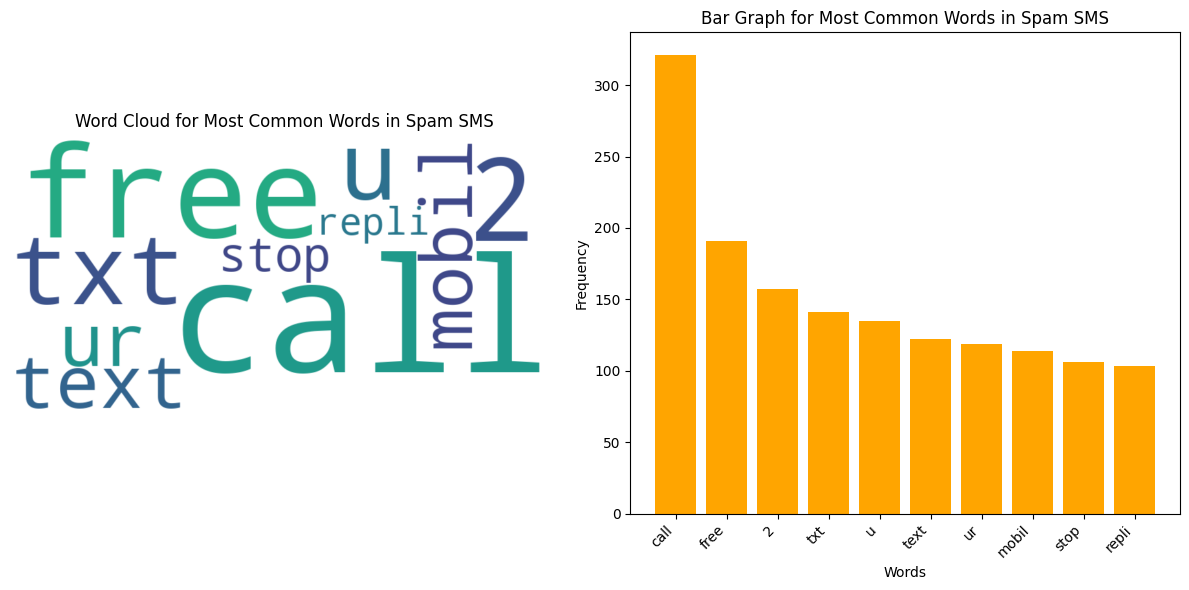

In [24]:
spam_sms = data[data['result'] == 'spam']['transform_text']
spam_words = ' '.join(spam_sms).split()
word_counts = Counter(spam_words)
most_common_words = word_counts.most_common(10)

print("Top 10 Most Common Words in Spam SMS:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))

# Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in Spam SMS')
plt.axis('off')

# Plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in Spam SMS')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### Looking at the most common words found in spam SMS, we see patterns that spammers often use to catch our attention or convince us to act. Words like "call," "free," and "txt" show up frequently, suggesting offers or requests for action. This helps us understand what to watch out for in our SMS to avoid falling for spam. By knowing these common tricks, we can be more careful about which SMS we open or respond to, keeping our inboxes safer. SMS filters also use this information to better recognize and block spam messages, making our SMS experience more secure.

# 8) Most Common Words in ham SMS

Top 10 Most Common Words in Ham SMS:
u: 904 occurrences
go: 404 occurrences
nt: 352 occurrences
get: 352 occurrences
2: 290 occurrences
gt: 288 occurrences
lt: 287 occurrences
come: 275 occurrences
ok: 251 occurrences
got: 238 occurrences


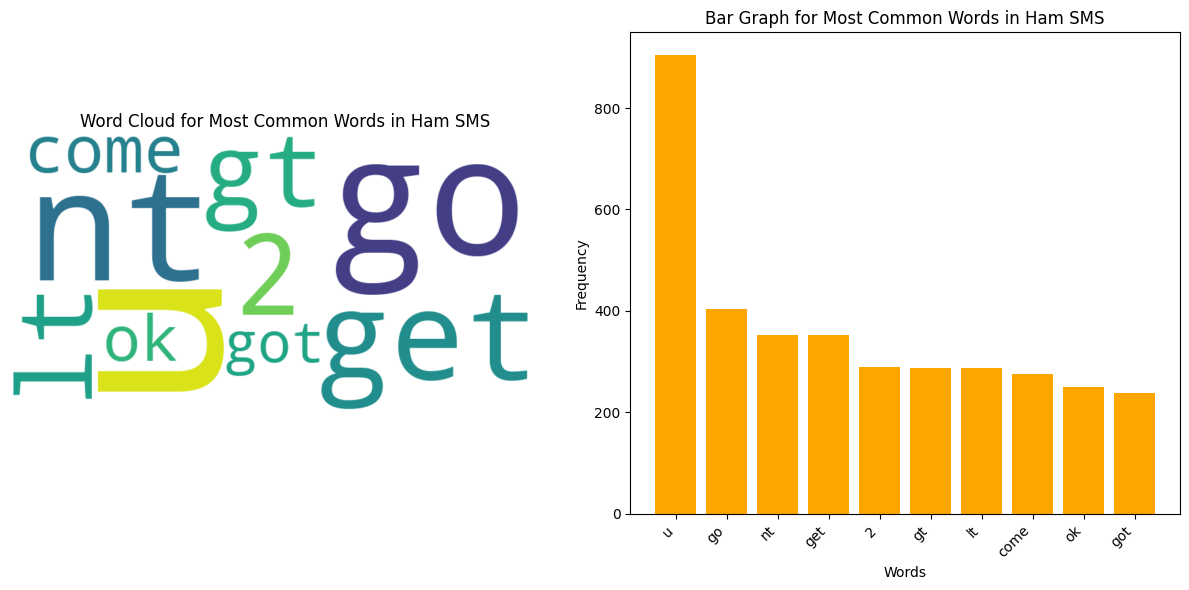

In [25]:
ham_sms = data[data['result'] == 'ham']['transform_text']
ham_words = ' '.join(ham_sms).split()
word_counts = Counter(ham_words)
most_common_words = word_counts.most_common(10)

print("Top 10 Most Common Words in Ham SMS:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))

# Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in Ham SMS')
plt.axis('off')

# Plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in Ham SMS')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


#### The top 10 most common words in non-spam SMS are "u," "go," "nt," "get," "2," "gt," "lt," "come," "ok," and "got." These words show how people talk in SMS, with shortcuts like "u" instead of "you" and "nt" for "not." They also reveal common topics like going somewhere or confirming things with "ok." Understanding these words helps in spotting normal SMS. It tells us what to expect in regular messages, making it easier to spot unusual or suspicious ones, like spam.

# Label Encoding

In [26]:
encoder = LabelEncoder()
data['result'] = encoder.fit_transform(data['result'])

In [27]:
data.sample(2)

,result,sms,Length,num_words,num_sentence,transform_text
3462,0,i am seeking a lady in the street and a freak ...,73,19,2,seek ladi street freak sheet
2057,0,"Nothing, i got msg frm tht unknown no..",39,10,1,noth got msg frm tht unknown


# Model Building

#### convert the input data into vector , so here we will use TfidfVectorizer


In [28]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data['transform_text']).toarray()
y = data['result']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
X.shape

(5169, 3000)

## Model 1) SVC

In [31]:
svc_classifier = SVC()
svc_classifier.fit(X_train, y_train)
y_pred_svc = svc_classifier.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"SVM Accuracy: {accuracy_svc:.2f}")
print("Confusion Matrix:", confusion_matrix(y_test, y_pred_svc))
print("Precision Score:", precision_score(y_test, y_pred_svc))

SVM Accuracy: 0.98
Confusion Matrix: [[889   0]
 [ 24 121]]
Precision Score: 1.0


## Model 2) Random Forest classifier

In [32]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print("Confusion Matrix:", confusion_matrix(y_test, y_pred_rf))
print("Precision Score:", precision_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.98
Confusion Matrix: [[888   1]
 [ 24 121]]
Precision Score: 0.9918032786885246


## Model 3) Naive Bayes classifier

In [33]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb:.2f}")
print("Confusion Matrix:", confusion_matrix(y_test, y_pred_nb))
print("Precision Score:", precision_score(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.98
Confusion Matrix: [[888   1]
 [ 24 121]]
Precision Score: 0.9918032786885246


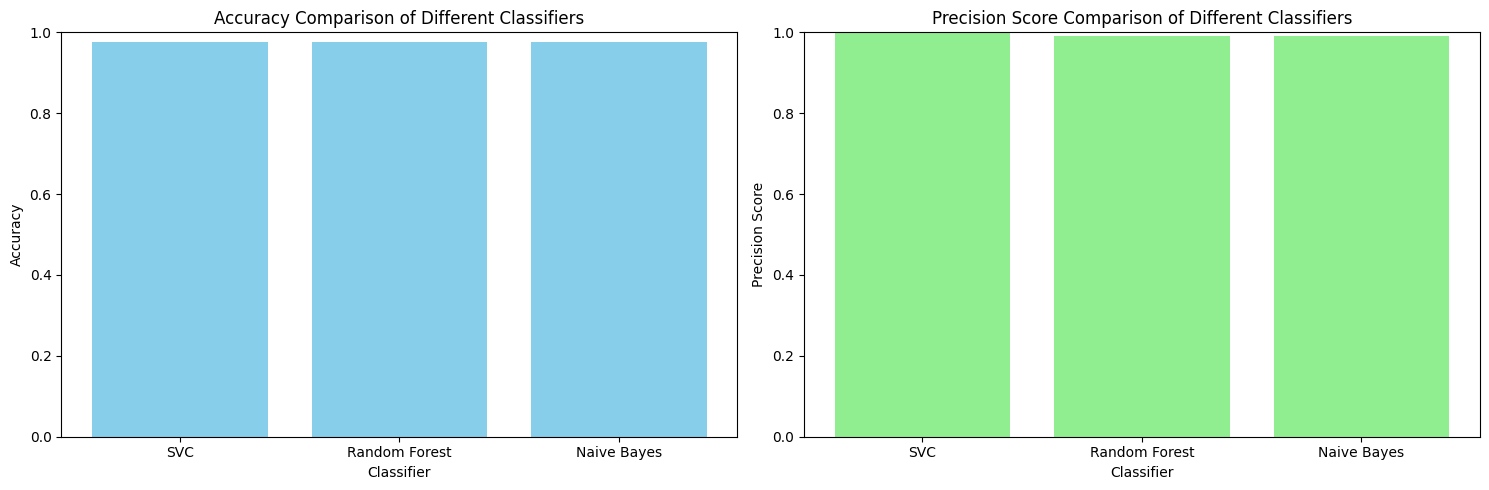

In [35]:
# Calculate precision scores for each classifier
precision_svc = precision_score(y_test, y_pred_svc)
precision_rf = precision_score(y_test, y_pred_rf)
precision_nb = precision_score(y_test, y_pred_nb)

# Create lists to store accuracies and precision scores
classifiers = ['SVC', 'Random Forest', 'Naive Bayes']
accuracies = [accuracy_svc, accuracy_rf, accuracy_nb]
precision_scores = [precision_svc, precision_rf, precision_nb]

# Plot bar graph for accuracies and precision scores side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot bar graph for accuracies
axes[0].bar(classifiers, accuracies, color='skyblue')
axes[0].set_xlabel('Classifier')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison of Different Classifiers')
axes[0].set_ylim(0, 1)

# Plot bar graph for precision scores
axes[1].bar(classifiers, precision_scores, color='lightgreen')
axes[1].set_xlabel('Classifier')
axes[1].set_ylabel('Precision Score')
axes[1].set_title('Precision Score Comparison of Different Classifiers')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

#### After sorting the model we find that SVC performs the best. So, we'll use  SVC to make price predictions with svc. predict(). This process helps us choose the most accurate model for predicting.